# Shared libraries and packages

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pysindy as ps

# "Final" Code

# Draft / Playground space below:

## Clayton Code

## Jackie Code

## Max Code

## Gaurav Code

## Richard Code

In [147]:
##############################
# Load data
# ref: https://github.com/jonathanhorrocks/SINDy-data/tree/master/Horrocks_Repo/data
##############################

import pandas as pd

chickenpox_data = pd.read_csv('data/OntarioChickenWeekly39_69.txt', sep="\t", header=None)
chickenpox_data.columns = ["week", "cases"]
rubella_data = pd.read_csv('data/OntarioRubellaWeekly39_69.txt', sep="\t", header=None)
rubella_data.columns = ["week", "cases"]

# Imports measles data matrix (stored as .mat file) - ref https://github.com/jonathanhorrocks/SINDy-data/blob/master/Horrocks_Repo/utils/susc_rec/SR_tester.m#L12C1-L13C54
# Columns: | Time | Cases | Population | Births |
import scipy.io
measles_data = pd.DataFrame(scipy.io.loadmat('data/mDataEW_N.mat')["mDataN"])
measles_data.columns = ["week", "cases", "population", "births"]

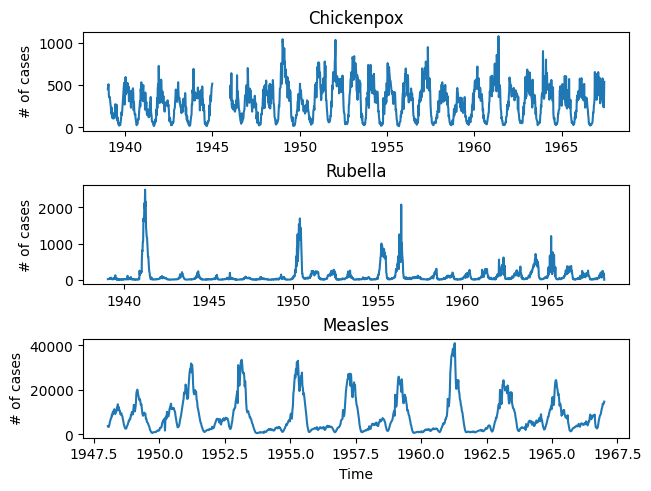

In [47]:
##############################
# Plot data
##############################

fig, ((ax1, ax2, ax3)) = plt.subplots(3, 1, layout="constrained")

ax1.plot(chickenpox_data["week"],chickenpox_data["cases"])
ax1.set_ylabel('# of cases')
ax1.set_title('Chickenpox')

ax2.plot(rubella_data["week"],rubella_data["cases"])
ax2.set_ylabel('# of cases')
ax2.set_title('Rubella')

ax3.plot(measles_data["week"],measles_data["cases"])
ax3.set_xlabel('Time')
ax3.set_ylabel('# of cases')
ax3.set_title('Measles')

plt.show()

From `Susceptible Reconstruction` section of [paper](https://www.nature.com/articles/s41598-020-63877-w.pdf):
$$Y_{t+1} = R_t - U_t Z_0 - (\alpha_{t+1} - \overline{\alpha} ) X_t + \alpha_{t+1} X_{t+1} + Z_{t+1} - u_{t+1}$$

where:
* $Y_t = \displaystyle{\sum_{i=1}^t B_{i-d,i-d+1}}$,
* $R_t = \displaystyle{\sum_{i=1}^t (\alpha_i - \overline{\alpha}) C_i}$,
* $U_t = \displaystyle{\sum_{i=1}^t u_i}$,
* $X_t = \displaystyle{\sum_{i=1}^t C_{i,i+1}}$,
* $B_{t,t+1}$ are the number of new births in week $t$
* $C_{t,t+1}$ are the number of new cases in week $t$
* $Z_t$ is the deviation from the mean Susceptible cases at week $t$, i.e. $S_t = \overline{S} + Z_t$,
* $\alpha_t$ is the rate at which cases are reported at week $t$,
* $u_t$ is the additive noise at week $t$ (assumed to be random Normal - $E(u) = 0, V(u) = \sigma_u^2$)


In [ ]:
####
# TODO: Build "Susceptible" Estimation 
####

Some data cleanup appears to be necessary in some of the datasets...

In [150]:
# Identify rows that are NaN in rubella dataset
print("The following rows have a value of NaN:")
print(rubella_data[rubella_data["cases"].isnull()])

# Scrub the NaN rows and create a new rubella_data_nonan set
print("Linearly interpolating NaN rows...")
rubella_data_nonan = rubella_data.copy()
rubella_data_nonan["cases"] = rubella_data["cases"].interpolate(method='linear', limit_direction='forward', axis=0)

print("The following rows of rubella_data_nonan now have a value of NaN (should be empty):")
print(rubella_data_nonan[rubella_data_nonan["cases"].isnull()],"\n")

# Remove the rows where "week" is not montonically inccreasing:
rubella_data_nonan['increasing'] = np.where(rubella_data_nonan['week'] > rubella_data_nonan['week'].shift(), 1, 0)
rubella_data_nonan.loc[0,'increasing'] = 1
print("The following rows have a non-increasing value for 'weeks':")
print(rubella_data_nonan[rubella_data_nonan['increasing'] == False])
print(rubella_data_nonan[197:201],"\n")

rubella_data_nonan_inc = rubella_data_nonan.copy()

print("Swapping non-increasing data values...")
rubella_data_nonan_inc.iloc[[198]] = rubella_data_nonan.iloc[[199]]
rubella_data_nonan_inc.iloc[[199]] = rubella_data_nonan.iloc[[198]]

rubella_data_nonan_inc['increasing'] = np.where(rubella_data_nonan_inc['week'] > rubella_data_nonan_inc['week'].shift(), 1, 0)
rubella_data_nonan_inc.loc[0,'increasing'] = 1
print("The following rows have a non-increasing value for 'weeks' (should be empty):")
print(rubella_data_nonan_inc[rubella_data_nonan_inc['increasing'] == False])

The following rows have a value of NaN:
            week  cases
29   1939.574949    NaN
397  1946.627652    NaN
712  1952.664613    NaN
Linearly interpolating NaN rows...
The following rows of rubella_data_nonan now have a value of NaN (should be empty):
Empty DataFrame
Columns: [week, cases]
Index: [] 

The following rows have a non-increasing value for 'weeks':
            week  cases  increasing
199  1942.805613    8.0           0
            week  cases  increasing
197  1942.794661    8.0           1
198  1942.813826    5.0           1
199  1942.805613    8.0           0
200  1942.852156    7.0           1 

Swapping non-increasing data values...
The following rows have a non-increasing value for 'weeks' (should be empty):
Empty DataFrame
Columns: [week, cases, increasing]
Index: []


In [ ]:
##############################
# Construct SINDy model - NOTE: this does not appear to be functional; probably need to (1) denoise and/or (2) add Susceptible data
##############################

differentiation_method = ps.FiniteDifference(order=1)
feature_library = ps.PolynomialLibrary(degree=2)
optimizer = ps.STLSQ(threshold=0.3)

rubella_model = ps.SINDy(
    differentiation_method=differentiation_method,
    feature_library=feature_library,
    optimizer=optimizer,
    feature_names=["i"]
)

rubella_model.fit(rubella_data_nonan_inc["cases"].values, t=rubella_data_nonan_inc["week"].values)
rubella_model.print()

(i)' = 593.682 1 + -5.147 i


/home/rdcarini/Documents/Projects/pysindy-venv/lib/python3.12/site-packages/pysindy/utils/axes.py:126: AxesWarning: 2 axes labeled for array with 1 axes
  warnings.warn(


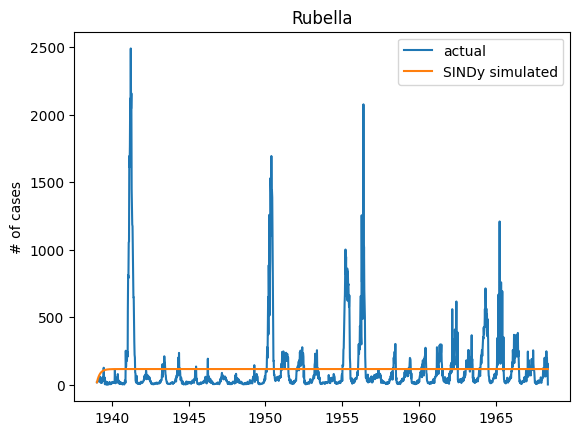

In [152]:
##############################
# Simulate using SINDy model
##############################

init_value = [rubella_data_nonan_inc["cases"][0]]
sim = rubella_model.simulate(init_value, t=rubella_data_nonan_inc["week"].values)

##############################
# Plot data
##############################

fig, ((ax)) = plt.subplots(1, 1)

ax.plot(rubella_data_nonan_inc["week"], rubella_data_nonan_inc["cases"], label="actual")
ax.plot(rubella_data_nonan_inc["week"], sim, label="SINDy simulated")
ax.set_ylabel('# of cases')
ax.set_title('Rubella')
ax.legend()

plt.show()